## Import

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [2]:
import random
import pandas as pd
import numpy as np
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import torchvision.models as models
import cv2
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [4]:
CFG = {
    'IMG_SIZE':512,
    'EPOCHS':80,
    'LEARNING_RATE': 0.0003235,
    "WEIGHT_DECAY": 0.002601,
    'BATCH_SIZE':10,
    'NUM_WORKERS': 4,
    'FOLD_NUMBER': 3,
    'SEED':41
}


In [5]:
# from sklearn.model_selection import KFold

# # K-Fold 설정
# k_folds = 10
# kfold = KFold(n_splits=k_folds, shuffle=True)

# # 결과를 저장하기 위한 리스트
# results = []

# train_ids_list = []
# val_ids_list = []

# for fold, (train_ids, val_ids) in enumerate(kfold.split(train_df)):
#     train_ids_list.append(train_ids)
#     val_ids_list.append(val_ids)
    
    
# train_ids_list = np.array(train_ids_list)
# val_ids_list = np.array(val_ids_list)

# np.savez('./KFold_10.npz', train_ids_list=train_ids_list, val_ids_list=val_ids_list)

kfold = np.load('./KFold_10.npz')
train_ids = kfold['train_ids_list'][CFG['FOLD_NUMBER']]
val_ids = kfold['val_ids_list'][CFG['FOLD_NUMBER']]
(train_ids.shape, val_ids.shape)

((63000,), (7000,))

# Recode

In [6]:
import yaml
from datetime import datetime

current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d %H:%M:%S")
save_folder = os.path.join(os.getcwd(), 'result', formatted_datetime)

os.makedirs("./result", exist_ok=True)
os.makedirs(save_folder, exist_ok=True)

# with open(os.path.join(save_folder, "config.yaml"), 'w') as yaml_file:
#     yaml.dump(CFG, yaml_file, default_flow_style=False)

In [7]:
import csv
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from typing import Dict
import os

# Define the function to record data and save plots without displaying them
def record(data: Dict[str, float], font_path="/home/hyj/ChanHyung/SSL/PUZZLE_AI/OPTITimesRoman-Italic.otf"):
    # Define the filenames for the CSV and plots
    csv_filename = os.path.join(save_folder, 'training_data.csv')
    plot_filenames = {
        'val_loss': os.path.join(save_folder, 'val_loss_plot.png'),
        'val_accuracy': os.path.join(save_folder, 'val_accuracy_plot.png'),
        'val_dacon_score': os.path.join(save_folder, 'val_dacon_score_plot.png')
    }

    # Append the data to the CSV
    fieldnames = list(data.keys())
    try:
        # Check if the CSV already exists to append or write headers
        with open(csv_filename, 'x', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerow(data)
    except FileExistsError:
        with open(csv_filename, 'a', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=fieldnames)
            writer.writerow(data)

    # Read the updated data for plotting
    with open(csv_filename, newline='') as file:
        reader = csv.DictReader(file)
        epochs = []
        metrics = {key: [] for key in data.keys()}
        for i, row in enumerate(reader):
            epochs.append(i + 1)  # Assuming each row is a new epoch
            for key in data.keys():
                metrics[key].append(float(row[key]))

    # Set up the custom font
    prop = FontProperties(fname=font_path)

    # Create and save the plots without displaying them
    plt.ioff()  # Turn off interactive mode to prevent displaying figures
    
    # Plot val_loss
    plt.figure()
    plt.plot(epochs, metrics['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs', fontproperties=prop)
    plt.ylabel('Validation Loss', fontproperties=prop)
    plt.title('Validation Loss over Epochs', fontproperties=prop)
    plt.legend(prop=prop)
    plt.savefig(plot_filenames['val_loss'])

    # Plot val_1x1, val_2x2, val_3x3, val_4x4 in one graph
    plt.figure()
    plt.plot(epochs, metrics['val_1x1'], label='1x1 Accuracy')
    plt.plot(epochs, metrics['val_2x2'], label='2x2 Accuracy')
    plt.plot(epochs, metrics['val_3x3'], label='3x3 Accuracy')
    plt.plot(epochs, metrics['val_4x4'], label='4x4 Accuracy')
    plt.xlabel('Epochs', fontproperties=prop)
    plt.ylabel('Accuracy', fontproperties=prop)
    plt.title('Validation Accuracy over Epochs', fontproperties=prop)
    plt.legend(prop=prop)
    plt.savefig(plot_filenames['val_accuracy'])

    # Plot val_dacon_score
    plt.figure()
    plt.plot(epochs, metrics['val_dacon_score [AVG]'], label='Dacon Score')
    plt.xlabel('Epochs', fontproperties=prop)
    plt.ylabel('Dacon Score', fontproperties=prop)
    plt.title('Dacon Score over Epochs', fontproperties=prop)
    plt.legend(prop=prop)
    plt.savefig(plot_filenames['val_dacon_score'])

    plt.ion()  # Turn interactive mode back on

    # Return paths of generated files
    return {
        'csv_file': csv_filename,
        'plot_files': plot_filenames
    }


In [8]:
def optimizer_to_yaml_dict(optimizer):
    return {
        'type': optimizer.__class__.__name__,
        'defaults': {k: v if not isinstance(v, torch.Tensor) else 'Tensor' for k, v in optimizer.defaults.items()}
    }

# Function to convert a scheduler to a YAML-compatible dictionary
def scheduler_to_yaml_dict(scheduler):
    return {
        'type': scheduler.__class__.__name__,
        'scheduler_params': {
            'mode': scheduler.mode,
            'factor': scheduler.factor,
            'patience': scheduler.patience,
            'threshold_mode': scheduler.threshold_mode,
            'min_lr': scheduler.min_lrs,
            'verbose': scheduler.verbose
        }
    }

# Function to convert a criterion to a YAML-compatible dictionary
def criterion_to_yaml_dict(criterion):
    return {
        'type': criterion.__class__.__name__
    }


def transform_to_dict(transform):
    transform_list = []
    for t in transform.transforms:
        transform_name = t.__class__.__name__
        params = {k: v for k, v in t.__dict__.items() if not k.startswith('_')}
        transform_list.append({transform_name: params or None})
    return transform_list

## Fixed RandomSeed

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['SEED']) # Seed 고정

## Data Load

In [10]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

## Data Preprocessing

In [11]:
#train_labels = train_df.iloc[:,2:].values.reshape(-1, 4, 4)

val_df = train_df.iloc[val_ids]
train_df = train_df.iloc[train_ids]

train_labels = train_df.iloc[:,2:].values.reshape(-1, 4, 4)
val_labels = val_df.iloc[:,2:].values.reshape(-1, 4, 4)

print(train_labels.shape, val_labels.shape)

(63000, 4, 4) (7000, 4, 4)


## CustomDataset

In [12]:
import albumentations as A
from albumentations.core.transforms_interface import DualTransform
import numpy as np
import cv2

class CustomCutout(DualTransform):
    def __init__(self, min_cutout_fraction=0.3, always_apply=False, p=0.5):
        super(CustomCutout, self).__init__(always_apply, p)
        self.min_cutout_fraction = min_cutout_fraction

    def apply(self, image, **params):
        height, width = image.shape[:2]
        # Divide the image into 16 equal parts
        h_step, w_step = height // 4, width // 4

        for h in range(4):
            for w in range(4):
                # Calculate the center of each block
                center_x, center_y = w_step * w + w_step // 2, h_step * h + h_step // 2
                # Calculate random cutout size
                min_size = int(min(h_step, w_step) * self.min_cutout_fraction)
                max_size = min(h_step, w_step) // 2
                cutout_size = np.random.randint(min_size, max_size)
                # Apply the cutout
                x1 = max(center_x - cutout_size // 2, 0)
                y1 = max(center_y - cutout_size // 2, 0)
                x2 = min(center_x + cutout_size // 2, width)
                y2 = min(center_y + cutout_size // 2, height)
                image[y1:y2, x1:x2] = 0
        return image
    
class EdgeCutout(DualTransform):
    def __init__(self, cutout_size=20, always_apply=False, p=0.5):
        super(EdgeCutout, self).__init__(always_apply, p)
        self.cutout_size = cutout_size

    def apply(self, image, **params):
        height, width = image.shape[:2]
        # Calculate the step size for each block
        h_step, w_step = height // 4, width // 4

        # Apply cutout at each intersection
        for h in range(1, 4):
            for w in range(1, 4):
                center_x, center_y = w * w_step, h * h_step
                x1 = max(center_x - self.cutout_size // 2, 0)
                y1 = max(center_y - self.cutout_size // 2, 0)
                x2 = min(center_x + self.cutout_size // 2, width)
                y2 = min(center_y + self.cutout_size // 2, height)
                image[y1:y2, x1:x2] = 0
        return image

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transform=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.label_list is not None:
            label = self.label_list[index]

            if self.transform is not None:
                transformed = self.transform(image=image)
                image = transformed['image']

            label = torch.tensor(label, dtype=torch.long) - 1
            return image, label
        else:
            if self.transform is not None:
                image = self.transform(image=image)['image']
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [13]:
# train_transform = transforms.Compose([
#     transforms.ToTensor(),
#     #transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# test_transform = transforms.Compose([
#     transforms.ToTensor(),
#     #transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])
    # A.RandomBrightnessContrast(p=0.5),
import albumentations as A
from albumentations.pytorch import ToTensorV2


train_transform = A.Compose([
    # A.RandomBrightnessContrast(p=0.5),
    # A.OneOf([
    #       A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
    #       A.ChannelShuffle(p=1),
    #       A.CLAHE(p=1.0)
    # ], p=1),
    A.RandomBrightnessContrast(p=0.5),
    A.OneOf([
          A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
          A.ChannelShuffle(p=1),
          A.CLAHE(p=1.0),
          CustomCutout(p=1),
          EdgeCutout(p=1)
    ], p=1),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])


In [14]:
train_dataset = CustomDataset(train_df['img_path'].values, train_labels, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], 
                          shuffle=True, num_workers=CFG['NUM_WORKERS'], 
                          pin_memory=True)

val_dataset = CustomDataset(val_df['img_path'].values, val_labels, test_transform)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], 
                        shuffle=False, num_workers=CFG['NUM_WORKERS'], 
                        pin_memory=True)

test_dataset = CustomDataset(test_df['img_path'].values, None, test_transform)
test_loader = DataLoader(
                         test_dataset, batch_size = CFG['BATCH_SIZE'], 
                         shuffle=False, num_workers=CFG['NUM_WORKERS'], 
                         pin_memory=True)


In [15]:
# DataLoader에서 첫 번째 배치 가져오기
data_iter = iter(train_loader)
images, target = next(data_iter)

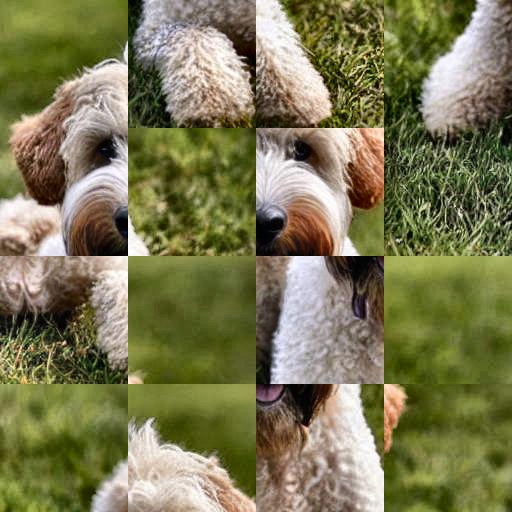

tensor([[ 1, 13, 15,  8],
        [ 5, 11,  6, 12],
        [14,  3,  9,  0],
        [ 4,  2, 10,  7]])


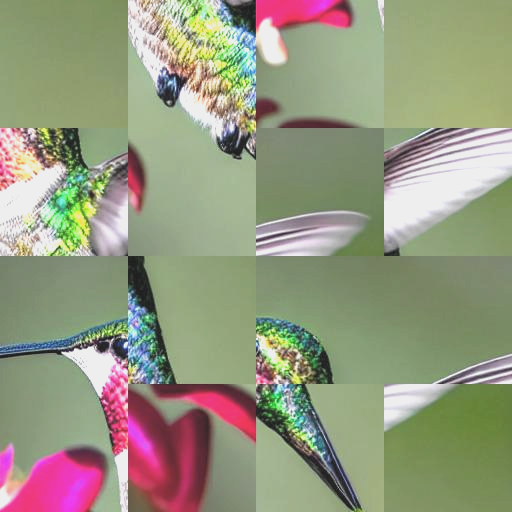

tensor([[11,  9,  8, 15],
        [ 5, 13,  3,  6],
        [ 0, 10,  1,  2],
        [ 4, 12, 14,  7]])


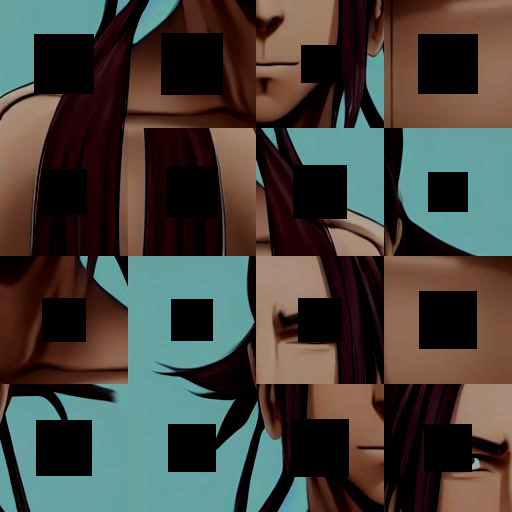

tensor([[ 8,  9,  6, 14],
        [12, 15, 11,  3],
        [10,  0,  2, 13],
        [ 7,  4,  5,  1]])


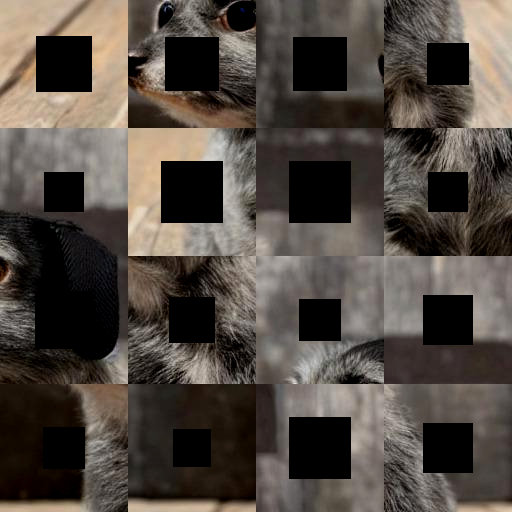

tensor([[12,  5,  4, 15],
        [ 2, 13,  7, 14],
        [ 6, 10,  1,  3],
        [ 9,  8,  0, 11]])


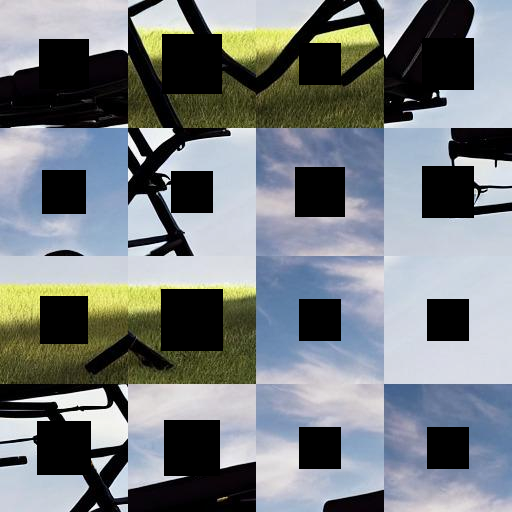

tensor([[ 6, 14, 13,  7],
        [ 3, 10,  0,  8],
        [12, 15,  2, 11],
        [ 9,  5,  4,  1]])


In [16]:
from PIL import Image

def imshow(img):
    # unnormalize
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)  # 값이 0과 1 사이에 있도록 클리핑
    return Image.fromarray((img * 255).astype(np.uint8))

# 이미지를 하나씩 출력
num_images_to_show = 5  # 시각화할 이미지 개수

for i in range(num_images_to_show):
    image = imshow(images[i])
    display(image)
    print(target[i])


In [17]:
import torch
import torch.nn as nn
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation

class Jigsaw_Solver(nn.Module):
    def __init__(self):
        super(Jigsaw_Solver, self).__init__()
        processor = AutoImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
        segformer = SegformerForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")
        segformer.decode_head.classifier = nn.Conv2d(768, 16, kernel_size=(1, 1), stride=(1, 1))
        
        self.segformer = segformer
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.reduce = nn.AdaptiveAvgPool2d((4, 4))

    def forward(self, x):
        x = self.segformer(x).logits
        x = self.bn1(x)
        x = self.relu1(x)
        return self.reduce(x)


input_tensor = torch.randn(1, 3, 512, 512)
model = Jigsaw_Solver()
output = model(input_tensor)
print(f"Output shape: {output.shape}")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Output shape: torch.Size([1, 16, 4, 4])


In [18]:
def calc_dacon_metric(preds, labels):
    accuracies = {}
    accuracies['1x1'] = (preds == labels).sum() / (labels.shape[0] * labels.shape[1])

    combinations_2x2 = [(i, j) for i in range(3) for j in range(3)]
    combinations_3x3 = [(i, j) for i in range(2) for j in range(2)]

    for size in range(2, 5):
        correct_count = 0  
        total_subpuzzles = 0

        for predicted_label, label in zip(preds, labels):
            puzzle_a = predicted_label.reshape(4, 4)
            puzzle_s = label.reshape(4, 4)
            combinations = combinations_2x2 if size == 2 else combinations_3x3 if size == 3 else [(0, 0)]

            for start_row, start_col in combinations:
                rows = slice(start_row, start_row + size)
                cols = slice(start_col, start_col + size)
                if np.array_equal(puzzle_a[rows, cols], puzzle_s[rows, cols]):
                    correct_count += 1
                total_subpuzzles += 1
            accuracies[f'{size}x{size}'] = correct_count / total_subpuzzles


    score = (accuracies['1x1'] + accuracies['2x2'] + accuracies['3x3'] + accuracies['4x4']) / 4.
    return accuracies



## Train

In [19]:
def train(model, optimizer, scheduler, train_loader, val_loader, device):
    model.to(device)
    model = nn.DataParallel(model)
    criterion = nn.CrossEntropyLoss().to(device)

    
    best_val_acc = 0
    best_val_loss = 999999999999
    best_model = None
    
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        all_predictions = []
        all_labels = []

        with tqdm(iter(train_loader)) as tqdm_train_loader:
            for imgs, labels in tqdm_train_loader:
                imgs, labels = imgs.float().to(device), labels.to(device)
                optimizer.zero_grad()

            # AMP를 사용한 순전파 및 역전파
                output = model(imgs)
                loss = criterion(output, labels)

                loss.backward()
                optimizer.step()
                train_loss.append(loss.item())
                
                predicted_labels = torch.argmax(output, dim=1).view(-1, 16)
                predicted_labels = predicted_labels.cpu().detach().numpy()

                all_predictions.extend(predicted_labels)
                all_labels.extend(labels.view(-1,16).cpu().detach().numpy())

                train_loss.append(loss.item())
                    
        
        
        all_predictions = np.vstack(all_predictions)
        all_labels = np.vstack(all_labels)
        _train_accuracies = calc_dacon_metric(all_predictions, all_labels)
        _train_dacon_score = (_train_accuracies['1x1'] + _train_accuracies['2x2'] + _train_accuracies['3x3'] + _train_accuracies['4x4']) / 4.
        
        _val_loss, _accuracies  = validation(model, criterion, val_loader, device)
        _val_dacon_score = (_accuracies['1x1'] + _accuracies['2x2'] + _accuracies['3x3'] + _accuracies['4x4']) / 4.
        scheduler.step(_val_loss)
        
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val 1x1 ACC : [{_accuracies["1x1"]:.5f}] Val Dacon: [{_val_dacon_score:.5f}]')

        
        config_data = {
                    'train_loss': _train_loss,
                    'train_1x1': _train_accuracies['1x1'],
                    'train_2x2': _train_accuracies['2x2'],
                    'train_3x3': _train_accuracies['3x3'],
                    'train_4x4': _train_accuracies['4x4'],
                    'train_dacon_score [AVG]': _train_dacon_score,
                    'val_loss': _val_loss,
                    'val_1x1': _accuracies['1x1'],
                    'val_2x2': _accuracies['2x2'],
                    'val_3x3': _accuracies['3x3'],
                    'val_4x4': _accuracies['4x4'],
                    'val_dacon_score [AVG]': _val_dacon_score,
                    }
        record(config_data)
        # wandb.log(config_data)
        
        if best_val_acc < _accuracies["1x1"]:
            best_val_acc = _accuracies["1x1"]
            best_model = model
            model_save_path = os.path.join(save_folder, "best_model.pth")
            torch.save(model, model_save_path)
            
    return best_model



In [20]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
        
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        with tqdm(iter(val_loader)) as tqdm_val_loader:
            for imgs, labels in tqdm_val_loader:
                imgs = imgs.float().to(device)
                labels = labels.to(device)

                output = model(imgs)
                loss = criterion(output, labels)

                val_loss.append(loss.item())

                predicted_labels = torch.argmax(output, dim=1).view(-1, 16)
                predicted_labels = predicted_labels.cpu().detach().numpy()

                all_predictions.extend(predicted_labels)
                all_labels.extend(labels.view(-1,16).cpu().detach().numpy())
        
        all_predictions = np.vstack(all_predictions)
        all_labels = np.vstack(all_labels)
        
        _val_loss = np.mean(val_loss)
        _accuracies = calc_dacon_metric(all_predictions, all_labels)
    
    return _val_loss, _accuracies 

## Run!!

In [21]:
optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"], weight_decay=CFG["WEIGHT_DECAY"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,
                                                        threshold_mode='abs',min_lr=1e-8, verbose=True)
criterion = nn.CrossEntropyLoss()


In [22]:
from torchinfo import summary
summary(model, (CFG['BATCH_SIZE'], 3, 512, 512))

Layer (type:depth-idx)                                                           Output Shape              Param #
Jigsaw_Solver                                                                    [10, 16, 4, 4]            --
├─SegformerForSemanticSegmentation: 1-1                                          [10, 16, 128, 128]        --
│    └─SegformerModel: 2-1                                                       [10, 64, 128, 128]        --
│    │    └─SegformerEncoder: 3-1                                                [10, 64, 128, 128]        24,196,288
│    └─SegformerDecodeHead: 2-2                                                  [10, 16, 128, 128]        --
│    │    └─ModuleList: 3-2                                                      --                        789,504
│    │    └─Conv2d: 3-3                                                          [10, 768, 128, 128]       2,359,296
│    │    └─BatchNorm2d: 3-4                                                     [10, 768, 128,

In [23]:
# Define the path for the config YAML file
config_yaml_path = os.path.join(save_folder, "config.yaml")

transform_data = {
    'train_transform': transform_to_dict(train_transform),
    'test_transform': transform_to_dict(test_transform)
}


serialized_data = {
    'optimizer': optimizer_to_yaml_dict(optimizer),
    'scheduler': scheduler_to_yaml_dict(scheduler),
    'criterion': criterion_to_yaml_dict(criterion)
}

# Combine all the dictionaries into one
combined_config = {
    'CFG': CFG,
    'transform_data': transform_data,
    'training_data': serialized_data
}

config_yaml_path = os.path.join(save_folder, "config.yaml")

# Write the combined config data to the YAML file
with open(config_yaml_path, 'w') as file:
    yaml.dump(combined_config, file, default_flow_style=False, indent=4)



In [24]:
#model = nn.DataParallel(model)
infer_model = train(model, optimizer, scheduler, train_loader, val_loader, device)

  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.64984] Val Loss : [0.11899] Val 1x1 ACC : [0.96273] Val Dacon: [0.88358]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.17733] Val Loss : [0.07644] Val 1x1 ACC : [0.97514] Val Dacon: [0.92248]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.12027] Val Loss : [0.04618] Val 1x1 ACC : [0.98491] Val Dacon: [0.95160]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.09766] Val Loss : [0.04527] Val 1x1 ACC : [0.98490] Val Dacon: [0.95108]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.07994] Val Loss : [0.04178] Val 1x1 ACC : [0.98588] Val Dacon: [0.95725]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.07100] Val Loss : [0.03720] Val 1x1 ACC : [0.98804] Val Dacon: [0.96476]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.06309] Val Loss : [0.02920] Val 1x1 ACC : [0.98994] Val Dacon: [0.96898]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.05734] Val Loss : [0.03529] Val 1x1 ACC : [0.98820] Val Dacon: [0.96384]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.05211] Val Loss : [0.05697] Val 1x1 ACC : [0.98099] Val Dacon: [0.94067]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 00010: reducing learning rate of group 0 to 1.6175e-04.
Epoch [10], Train Loss : [0.04872] Val Loss : [0.02982] Val 1x1 ACC : [0.98981] Val Dacon: [0.96819]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.02359] Val Loss : [0.01636] Val 1x1 ACC : [0.99482] Val Dacon: [0.98467]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.02022] Val Loss : [0.01660] Val 1x1 ACC : [0.99476] Val Dacon: [0.98402]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.01870] Val Loss : [0.01436] Val 1x1 ACC : [0.99516] Val Dacon: [0.98623]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.01858] Val Loss : [0.01441] Val 1x1 ACC : [0.99523] Val Dacon: [0.98610]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.01648] Val Loss : [0.01540] Val 1x1 ACC : [0.99501] Val Dacon: [0.98668]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 00016: reducing learning rate of group 0 to 8.0875e-05.
Epoch [16], Train Loss : [0.01700] Val Loss : [0.01593] Val 1x1 ACC : [0.99544] Val Dacon: [0.98667]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.00863] Val Loss : [0.01206] Val 1x1 ACC : [0.99624] Val Dacon: [0.98984]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.00782] Val Loss : [0.01247] Val 1x1 ACC : [0.99648] Val Dacon: [0.98987]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.00661] Val Loss : [0.01077] Val 1x1 ACC : [0.99651] Val Dacon: [0.98991]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.00695] Val Loss : [0.01240] Val 1x1 ACC : [0.99668] Val Dacon: [0.98998]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.00619] Val Loss : [0.01094] Val 1x1 ACC : [0.99705] Val Dacon: [0.99116]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 00022: reducing learning rate of group 0 to 4.0438e-05.
Epoch [22], Train Loss : [0.00590] Val Loss : [0.01364] Val 1x1 ACC : [0.99632] Val Dacon: [0.99041]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.00376] Val Loss : [0.00836] Val 1x1 ACC : [0.99733] Val Dacon: [0.99216]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.00371] Val Loss : [0.00891] Val 1x1 ACC : [0.99723] Val Dacon: [0.99209]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.00311] Val Loss : [0.00829] Val 1x1 ACC : [0.99738] Val Dacon: [0.99110]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.00299] Val Loss : [0.00784] Val 1x1 ACC : [0.99754] Val Dacon: [0.99198]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.00301] Val Loss : [0.00856] Val 1x1 ACC : [0.99743] Val Dacon: [0.99226]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.00244] Val Loss : [0.00919] Val 1x1 ACC : [0.99723] Val Dacon: [0.99176]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 00029: reducing learning rate of group 0 to 2.0219e-05.
Epoch [29], Train Loss : [0.00294] Val Loss : [0.01102] Val 1x1 ACC : [0.99704] Val Dacon: [0.99177]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.00207] Val Loss : [0.00750] Val 1x1 ACC : [0.99773] Val Dacon: [0.99309]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [31], Train Loss : [0.00188] Val Loss : [0.00768] Val 1x1 ACC : [0.99771] Val Dacon: [0.99313]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [32], Train Loss : [0.00171] Val Loss : [0.00809] Val 1x1 ACC : [0.99764] Val Dacon: [0.99325]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 00033: reducing learning rate of group 0 to 1.0109e-05.
Epoch [33], Train Loss : [0.00159] Val Loss : [0.00853] Val 1x1 ACC : [0.99767] Val Dacon: [0.99339]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [34], Train Loss : [0.00150] Val Loss : [0.00760] Val 1x1 ACC : [0.99786] Val Dacon: [0.99372]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [35], Train Loss : [0.00140] Val Loss : [0.00684] Val 1x1 ACC : [0.99799] Val Dacon: [0.99362]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [36], Train Loss : [0.00117] Val Loss : [0.00646] Val 1x1 ACC : [0.99813] Val Dacon: [0.99411]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [37], Train Loss : [0.00113] Val Loss : [0.00638] Val 1x1 ACC : [0.99821] Val Dacon: [0.99457]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [38], Train Loss : [0.00115] Val Loss : [0.00719] Val 1x1 ACC : [0.99816] Val Dacon: [0.99458]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 00039: reducing learning rate of group 0 to 5.0547e-06.
Epoch [39], Train Loss : [0.00121] Val Loss : [0.00702] Val 1x1 ACC : [0.99807] Val Dacon: [0.99418]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [40], Train Loss : [0.00105] Val Loss : [0.00727] Val 1x1 ACC : [0.99815] Val Dacon: [0.99462]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [41], Train Loss : [0.00107] Val Loss : [0.00697] Val 1x1 ACC : [0.99826] Val Dacon: [0.99495]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 00042: reducing learning rate of group 0 to 2.5273e-06.
Epoch [42], Train Loss : [0.00101] Val Loss : [0.00684] Val 1x1 ACC : [0.99816] Val Dacon: [0.99460]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [43], Train Loss : [0.00095] Val Loss : [0.00685] Val 1x1 ACC : [0.99817] Val Dacon: [0.99466]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [44], Train Loss : [0.00092] Val Loss : [0.00682] Val 1x1 ACC : [0.99820] Val Dacon: [0.99464]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 00045: reducing learning rate of group 0 to 1.2637e-06.
Epoch [45], Train Loss : [0.00105] Val Loss : [0.00673] Val 1x1 ACC : [0.99816] Val Dacon: [0.99457]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [46], Train Loss : [0.00089] Val Loss : [0.00659] Val 1x1 ACC : [0.99816] Val Dacon: [0.99462]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [47], Train Loss : [0.00091] Val Loss : [0.00645] Val 1x1 ACC : [0.99826] Val Dacon: [0.99482]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 00048: reducing learning rate of group 0 to 6.3184e-07.
Epoch [48], Train Loss : [0.00098] Val Loss : [0.00640] Val 1x1 ACC : [0.99822] Val Dacon: [0.99473]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [49], Train Loss : [0.00095] Val Loss : [0.00634] Val 1x1 ACC : [0.99821] Val Dacon: [0.99473]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [50], Train Loss : [0.00107] Val Loss : [0.00640] Val 1x1 ACC : [0.99821] Val Dacon: [0.99480]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [51], Train Loss : [0.00089] Val Loss : [0.00643] Val 1x1 ACC : [0.99823] Val Dacon: [0.99481]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 00052: reducing learning rate of group 0 to 3.1592e-07.
Epoch [52], Train Loss : [0.00097] Val Loss : [0.00642] Val 1x1 ACC : [0.99823] Val Dacon: [0.99480]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [53], Train Loss : [0.00090] Val Loss : [0.00639] Val 1x1 ACC : [0.99825] Val Dacon: [0.99484]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [54], Train Loss : [0.00089] Val Loss : [0.00640] Val 1x1 ACC : [0.99825] Val Dacon: [0.99483]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 00055: reducing learning rate of group 0 to 1.5796e-07.
Epoch [55], Train Loss : [0.00092] Val Loss : [0.00641] Val 1x1 ACC : [0.99828] Val Dacon: [0.99488]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [56], Train Loss : [0.00084] Val Loss : [0.00638] Val 1x1 ACC : [0.99826] Val Dacon: [0.99487]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [57], Train Loss : [0.00089] Val Loss : [0.00638] Val 1x1 ACC : [0.99826] Val Dacon: [0.99487]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 00058: reducing learning rate of group 0 to 7.8979e-08.
Epoch [58], Train Loss : [0.00082] Val Loss : [0.00635] Val 1x1 ACC : [0.99828] Val Dacon: [0.99488]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [59], Train Loss : [0.00070] Val Loss : [0.00633] Val 1x1 ACC : [0.99827] Val Dacon: [0.99488]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [60], Train Loss : [0.00081] Val Loss : [0.00635] Val 1x1 ACC : [0.99828] Val Dacon: [0.99485]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 00061: reducing learning rate of group 0 to 3.9490e-08.
Epoch [61], Train Loss : [0.00097] Val Loss : [0.00638] Val 1x1 ACC : [0.99828] Val Dacon: [0.99488]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [62], Train Loss : [0.00086] Val Loss : [0.00634] Val 1x1 ACC : [0.99825] Val Dacon: [0.99484]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [63], Train Loss : [0.00082] Val Loss : [0.00637] Val 1x1 ACC : [0.99827] Val Dacon: [0.99488]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 00064: reducing learning rate of group 0 to 1.9745e-08.
Epoch [64], Train Loss : [0.00072] Val Loss : [0.00635] Val 1x1 ACC : [0.99827] Val Dacon: [0.99488]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [65], Train Loss : [0.00096] Val Loss : [0.00633] Val 1x1 ACC : [0.99825] Val Dacon: [0.99484]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [66], Train Loss : [0.00085] Val Loss : [0.00636] Val 1x1 ACC : [0.99827] Val Dacon: [0.99488]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [67], Train Loss : [0.00083] Val Loss : [0.00636] Val 1x1 ACC : [0.99827] Val Dacon: [0.99488]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [68], Train Loss : [0.00082] Val Loss : [0.00634] Val 1x1 ACC : [0.99827] Val Dacon: [0.99488]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [69], Train Loss : [0.00085] Val Loss : [0.00634] Val 1x1 ACC : [0.99827] Val Dacon: [0.99488]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [70], Train Loss : [0.00090] Val Loss : [0.00632] Val 1x1 ACC : [0.99826] Val Dacon: [0.99486]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [71], Train Loss : [0.00106] Val Loss : [0.00633] Val 1x1 ACC : [0.99826] Val Dacon: [0.99484]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [72], Train Loss : [0.00090] Val Loss : [0.00633] Val 1x1 ACC : [0.99826] Val Dacon: [0.99487]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [73], Train Loss : [0.00100] Val Loss : [0.00634] Val 1x1 ACC : [0.99828] Val Dacon: [0.99487]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [74], Train Loss : [0.00096] Val Loss : [0.00634] Val 1x1 ACC : [0.99827] Val Dacon: [0.99488]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [75], Train Loss : [0.00078] Val Loss : [0.00634] Val 1x1 ACC : [0.99825] Val Dacon: [0.99486]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [76], Train Loss : [0.00079] Val Loss : [0.00633] Val 1x1 ACC : [0.99827] Val Dacon: [0.99487]


  0%|          | 0/6300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [77], Train Loss : [0.00064] Val Loss : [0.00633] Val 1x1 ACC : [0.99827] Val Dacon: [0.99485]


  0%|          | 0/6300 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Inference

In [ ]:
model = torch.load("model_segformer_avg.pth").to(device)

In [ ]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)
            
            output = model(imgs)
            
            # 정확도 계산을 위한 예측 레이블 추출
            predicted_labels = torch.argmax(output, dim=1).view(-1, 16)
            predicted_labels = predicted_labels.cpu().detach().numpy()

            preds.extend(predicted_labels)
    
    return preds

In [ ]:
preds = inference(model, test_loader, device)

In [ ]:
preds[0].shape

## Submission

In [34]:
submit = pd.read_csv('./sample_submission.csv')

In [35]:
submit.iloc[:, 1:] = preds
submit.iloc[:, 1:] += 1

In [36]:
submit.to_csv('./baseline_submit16.csv', index=False)